# Product Sales Prediction

Fitting 3 folds for each of 54 candidates, totalling 162 fits


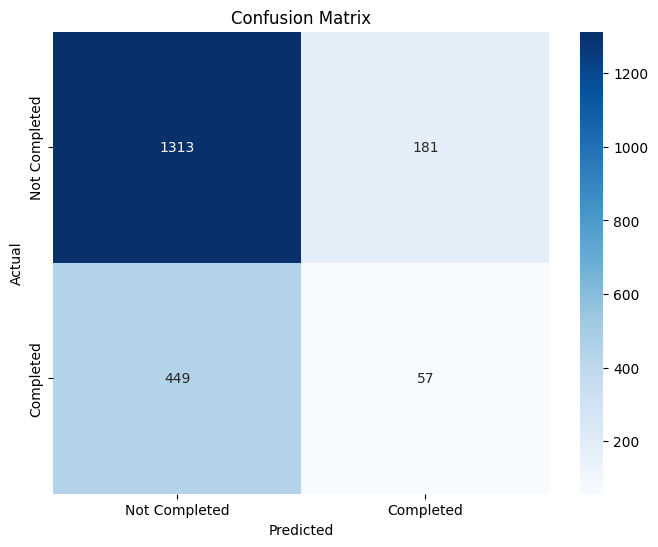

Accuracy: 68.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81      1494
           1       0.24      0.11      0.15       506

    accuracy                           0.69      2000
   macro avg       0.49      0.50      0.48      2000
weighted avg       0.62      0.69      0.64      2000

Confusion Matrix:
 [[1313  181]
 [ 449   57]]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pickle

# Import library tambahan yang dibutuhkan
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Contoh dataset untuk melatih model tambahan
price_data = pd.DataFrame({
    'Quantity': [10, 20, 5, 15, 25],
    'Current Price': [100, 200, 50, 150, 250],
    'Category_Electronics': [1, 0, 1, 0, 1],
    'Category_Books': [0, 1, 0, 1, 0],
    'Sales Time (Days)': [3, 7, 1, 5, 10],
    'Optimal Price': [90, 180, 45, 140, 230]  # Target harga optimal
})

# Preprocessing dataset untuk pelatihan model tambahan
X_price = price_data.drop(columns=['Optimal Price', 'Sales Time (Days)'])
y_price = price_data['Optimal Price']
X_time = price_data.drop(columns=['Optimal Price', 'Sales Time (Days)'])
y_time = price_data['Sales Time (Days)']

# Membagi dataset menjadi training dan testing set
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
X_time_train, X_time_test, y_time_train, y_time_test = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

# Melatih model regresi untuk rekomendasi harga optimal
price_model = RandomForestRegressor(n_estimators=100, random_state=42)
price_model.fit(X_price_train, y_price_train)

# Melatih model regresi untuk estimasi waktu penjualan
time_model = RandomForestRegressor(n_estimators=100, random_state=42)
time_model.fit(X_time_train, y_time_train)

# Load the dataset
data = pd.read_csv('larger_sales_dataset.csv')

# Ensure Total Price is in numeric format
if data['Total Price'].dtype == object:
    data['Total Price'] = data['Total Price'].str.replace('$', '').astype(float)

# Mapping 'Order Status' to a binary target: 1 if 'Completed', 0 otherwise
data['Target'] = data['Order Status'].apply(lambda x: 1 if x == 'Completed' else 0)

# Adding a feature for 'Payday Season'
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Payday Season'] = data['Order Date'].dt.day.apply(lambda x: 1 if 25 <= x <= 31 else 0)

# Adding new features to improve model performance
data['Price Per Quantity'] = data['Total Price'] / data['Quantity']
data['Is High Price'] = (data['Total Price'] > data['Total Price'].mean()).astype(int)

# Dropping irrelevant columns for the prediction task
relevant_data = data.drop(columns=['Order ID', 'Product ID', 'Customer ID', 'Order Date', 'Order Status'])

# One-hot encoding for categorical columns
encoded_data = pd.get_dummies(relevant_data, columns=['Product Category', 'Payment Type'], drop_first=True)

# Adding a feature for the average price per unit
encoded_data['Avg Price Per Unit'] = data['Total Price'] / data['Quantity']

# Ensuring feature names consistency
expected_features = ['Quantity', 'Total Price', 'Avg Price Per Unit', 'Payday Season', 'Price Per Quantity', 'Is High Price',
                     'Product Category_Books', 'Product Category_Clothing',
                     'Product Category_Electronics', 'Product Category_Home & Kitchen',
                     'Product Category_Sports & Outdoors', 'Payment Type_Debit Card',
                     'Payment Type_Gift Card', 'Payment Type_PayPal']

# Adding missing features with default values (if any)
for feature in expected_features:
    if feature not in encoded_data.columns:
        encoded_data[feature] = 0

# Splitting data into features (X) and target (y)
X = encoded_data[expected_features]
y = encoded_data['Target']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define a parameter grid for Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Perform Grid Search for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_resampled, y_resampled)

# Best model from Grid Search
best_gb_model = grid_search_gb.best_estimator_

# Evaluate the best model on the test set
y_pred = best_gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Completed", "Completed"], yticklabels=["Not Completed", "Completed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the trained model as a pickle file
MODEL_PATH = 'optimized_model.pkl'
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(best_gb_model, file)

# Output evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Save accuracy for future reference
accuracy_file_path = 'model_accuracy.txt'
with open(accuracy_file_path, 'w') as accuracy_file:
    accuracy_file.write(f"Accuracy: {accuracy * 100:.2f}%\n")
    accuracy_file.write(f"Classification Report:\n{classification_rep}\n")
    accuracy_file.write(f"Confusion Matrix:\n{conf_matrix}\n")


### Deployment using Streamlit